In [1]:
from steady_state import * 
from getpass import getpass
import arrow 
from dateutil import tz
from cognite.client import CogniteClient
from getpass import getpass
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

In [2]:
client = CogniteClient(
         api_key=getpass("Open Industrial Data API-KEY: "), 
         client_name="Steady State Detector notebook"
     )

Open Industrial Data API-KEY: ········


/Users/cimstordal/.local/share/virtualenvs/ssd-3IJuXT98/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Authenticated towards inferred project 'publicdata'. Pass project to the CogniteClient constructor or set the environment variable 'COGNITE_PROJECT' to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
start_date = datetime(2018, 3, 18)  # specify time series to pull from cdf
end_date = datetime(2018, 4, 2)
df = client.datapoints.retrieve(
     external_id="VAL_23-TIC-92604B:Z.X.Value",
     aggregates = ['average'],
     granularity='8m',
     start=start_date,
     end=end_date,
 ).to_pandas()
model = SSDetector(slope_threashold = 0.002, 
                   state_transition_probability = 0.5,
                   number_particles = 200, n_timeless = 20)  # using the default params

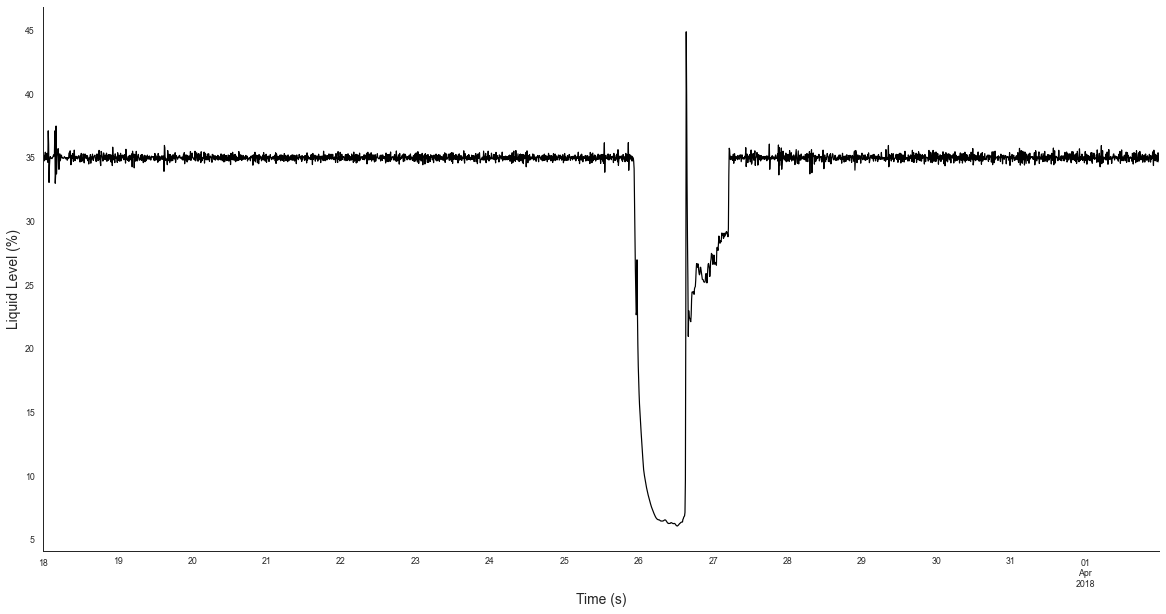

In [4]:
sns.set_style("white")
sns.set_context("paper")

ax = df.iloc[:,0].plot(figsize=(20,10), grid=False, 
                  color ='black')
ax.set_xlabel("Time (s)", fontsize = 'x-large')
ax.set_ylabel("Liquid Level (%)",fontsize = 'x-large')

sns.despine()
plt.savefig('ts')
plt.show()

In [5]:
model.train(np.squeeze(df.values, axis=1), # convert to % scale
            show_results = True)

t:  1 
y_hat:  -2.446756572289094 
Pt:  0.0
t: 2699 y_hat: 35.738809170302446 Pt:  0.999999999999999832.011385529930195 Pt:  0.999999999999999835.35491115315318 Pt:  0.9999999999999998

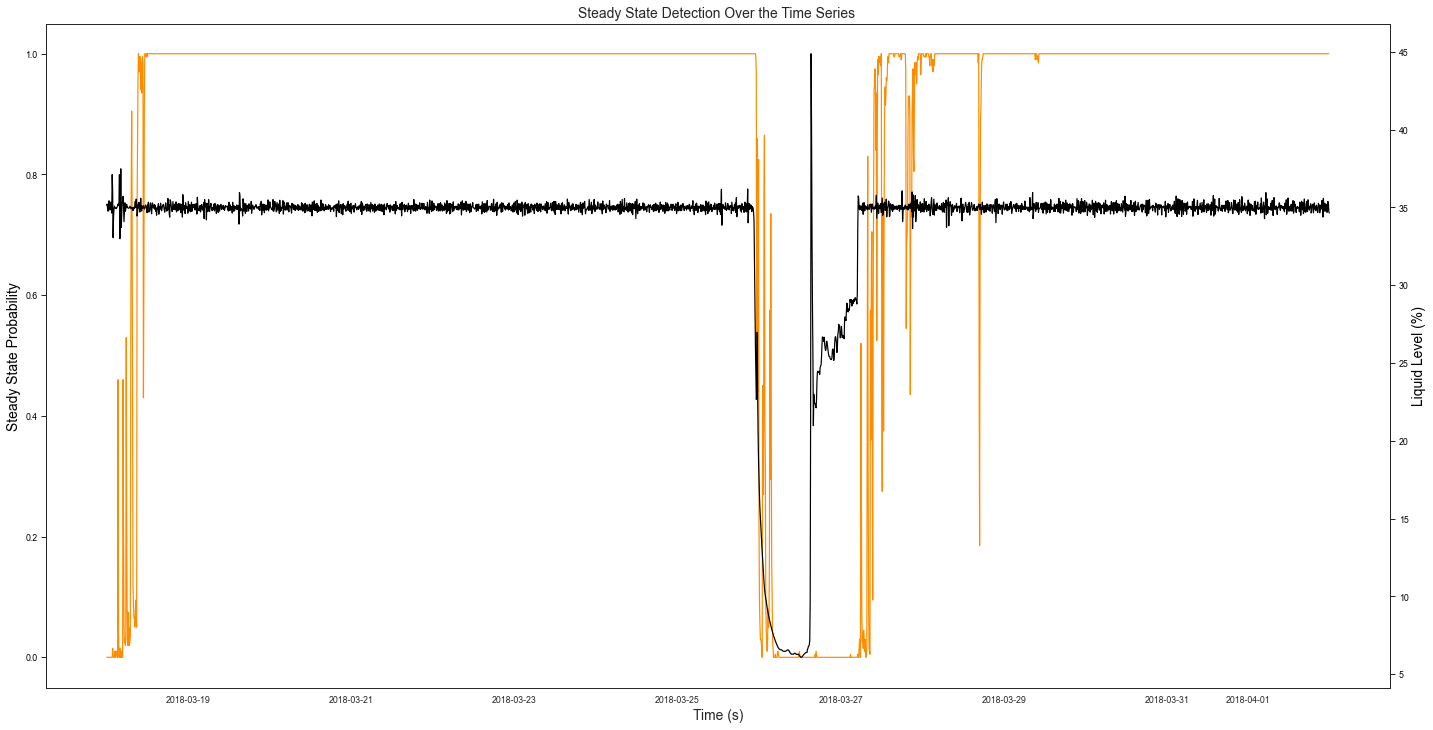

In [6]:
df['y_hat'] = model.y_hat
df['y_hat'] = df.y_hat.shift(-1)
df['p'] = model.p_steady
df['p'] = df.p.shift(-1)
plt.rcParams["figure.figsize"] = (20, 10)
z = np.arange(0, len(df), 1)  # time scale
fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel("Time (s)", fontsize = 'x-large')
ax1.set_ylabel("Steady State Probability", color='black', fontsize = 'x-large')
ax1.plot(df.index, df.p[0 : len(z)], color='darkorange')  # noqa: E203
ax1.tick_params(axis="y", labelcolor='black')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel('Liquid Level (%)', color='black', fontsize = 'x-large')  # we already handled the x-label with ax1
ax2.plot(df.index, df.iloc[:,0].values, color='black')
ax2.tick_params(axis="y", labelcolor='black')
ax2.grid(False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Steady State Detection Over the Time Series ", fontsize = 'x-large')
plt.savefig('ss_result_2')
plt.show()

In [7]:
df['is_steady'] = 0 
steady_idx = df[df['p'] > 0.98].index

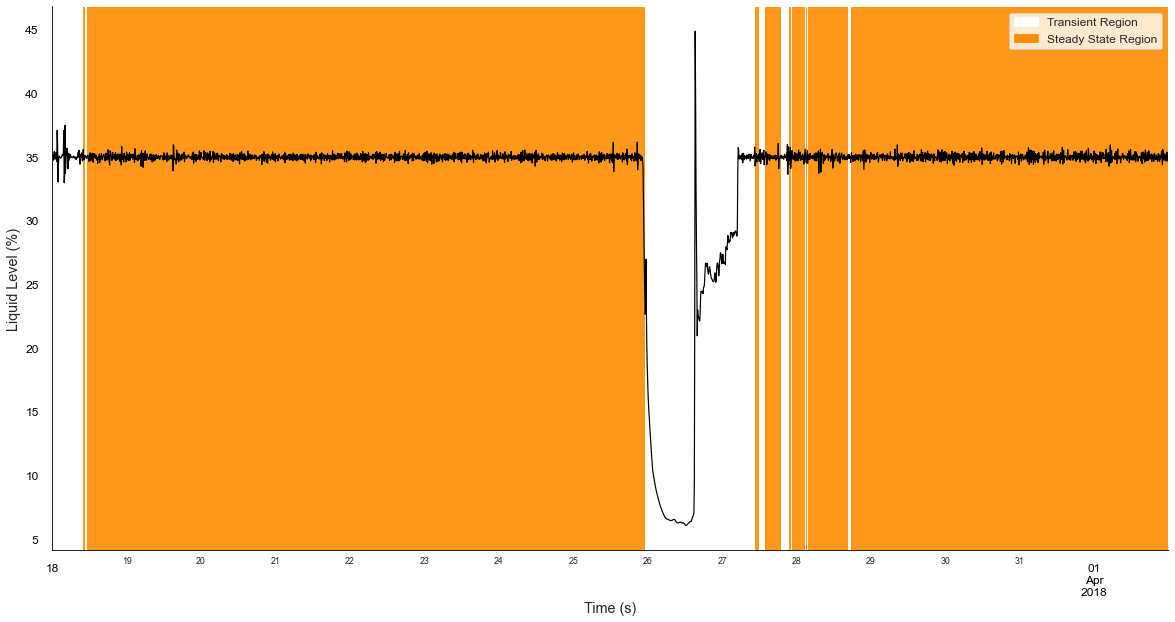

In [8]:
df.loc[steady_idx, 'is_steady'] = 1
import seaborn as sns 
import matplotlib.patches as mpatches
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

red_patch = mpatches.Patch(color="white", label='Transient Region')
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['white', 'darkorange']
)
green_patch = mpatches.Patch(color='darkorange', label='Steady State Region')
ax = df['VAL_23-TIC-92604B:Z.X.Value|average'].plot(color='black')
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
               df['is_steady'].values[np.newaxis],cmap = cmap,
               alpha=0.9)
ax.tick_params(direction='out', length=10, 
               width=10, colors='black', labelsize ='large')
ax.legend(fontsize = 'large', handles=[red_patch, green_patch])
ax.set_ylabel('Liquid Level (%)',fontsize = 'x-large' )
ax.set_xlabel('Time (s)',fontsize = 'x-large')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('ss_result')